# Mid-Sagittal plane algorithm

### Import relevant packages

In [ ]:
import os
import time
import gzip

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio

import nibabel as nib
from nibabel.orientations import aff2axcodes

import joblib

from scipy.ndimage import center_of_mass, find_objects
from scipy.optimize import minimize
from scipy.interpolate import RegularGridInterpolator

import ipywidgets as widgets
from matplotlib.lines import Line2D
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [ ]:
def load_nifti_file(file_path):
    """
    Load a NIfTI file and return its data and voxel size, reoriented to (coronal, sagittal, axial).

    Parameters
    ----------
    file_path : str
        Path to the NIfTI file.

    Returns
    -------
    tuple
        data : np.ndarray
            The image data array, reoriented to (coronal, sagittal, axial).
        voxel_size : np.ndarray
            The voxel size for each axis, reordered to match the data orientation.
    """
    nifti_img = nib.load(file_path)
    data = nifti_img.get_fdata()
    voxel_size = np.array(nifti_img.header.get_zooms())

    # determine which data-axis is world-X, world-Y, world-Z
    codes = aff2axcodes(nifti_img.affine)  
    code2world = {'L':0,'R':0,'P':1,'A':1,'I':2,'S':2}
    world_of_axis = [code2world[c] for c in codes]  
    # find data-axis indices for each world axis
    idx_x = world_of_axis.index(0)  # sagittal
    idx_y = world_of_axis.index(1)  # coronal
    idx_z = world_of_axis.index(2)  # axial

    # we want new_data[ coronal, sagittal, axial ]
    new_order = [idx_y, idx_x, idx_z]
    data = np.transpose(data, new_order)
    voxel_size = np.array(tuple(voxel_size[new_order]))

    return data, voxel_size

def open_gzip_file(gzip_file_path):
    """
    Open a gzip-compressed file and return its content as bytes.

    Parameters
    ----------
    gzip_file_path : str
        The path to the gzip file.

    Returns
    -------
    bytes or None
        The content of the gzip file, or None if an error occurs.
    """
    try:
        with gzip.open(gzip_file_path, 'rb') as f_in:
            file_content = f_in.read()
        return file_content
    except Exception as e:
        print(f'Error opening {gzip_file_path}: {e}')
        return None

def get_image_and_voxel_size_from_gzip(gzip_file_path):
    """
    Extract the image array and voxel size from a gzipped NIfTI file.

    Parameters
    ----------
    gzip_file_path : str
        Path to the gzipped NIfTI file.

    Returns
    -------
    tuple
        img_data : np.ndarray or None
            The image data array, or None if loading fails.
        voxel_size : np.ndarray or None
            The voxel size for each axis, or None if loading fails.
    """
    file_content = open_gzip_file(gzip_file_path)
    if file_content is not None:
        with open('temp_nifti.nii', 'wb') as temp_file:
            temp_file.write(file_content)

        # 🔹 Debugging: Check if the file was actually written
        file_size = os.path.getsize('temp_nifti.nii')
        if file_size == 0:
            print(f"❌ Error: 'temp_nifti.nii' was written but is empty! ({gzip_file_path})")
            return None, None

        img_data, voxel_size = load_nifti_file('temp_nifti.nii')
        os.remove('temp_nifti.nii')  # Remove temp file after reading
        
        return img_data, voxel_size
    else:
        print(f"❌ Error: Failed to read file content from '{gzip_file_path}'")
        return None, None

def load_patient_structures(patient_folder: str, structure_names=None):
    """
    Load specified structures from a patient folder containing NIfTI or gzipped NIfTI files.

    Parameters
    ----------
    patient_folder : str
        Path to the folder containing patient structure files.
    structure_names : list of str, optional
        List of structure names to load (default: ['Image']).

    Returns
    -------
    dict
        Dictionary mapping structure names to (image, voxel_size) tuples.
    """
    if structure_names is None:
        structure_names = ['Image']

    struct_dict = {}
    for root, _, files in os.walk(patient_folder):
        for f in files:
            # Only NIfTI files
            if not (f.endswith('.nii.gz') or f.endswith('.nii')):
                continue

            name_part = f
            
            # Remove extension
            if name_part.endswith('.nii.gz'):
                base = name_part[:-7]
            else:
                base = name_part[:-4]

            # Compare with expected structure names (case-insensitive)
            for struct_name in structure_names:
                if base.lower() == struct_name.lower():
                    file_path = os.path.join(root, f)
                    try:
                        if f.endswith('.nii.gz'):
                            img, voxel_size = get_image_and_voxel_size_from_gzip(file_path)
                        else:
                            img, voxel_size = load_nifti_file(file_path)
                    except Exception as e:
                        logging.error(f"Error loading '{struct_name}' from {file_path}: {e}")
                        continue

                    if img is not None:
                        struct_dict[struct_name] = (img, voxel_size)
                        print(f"Loaded '{struct_name}' from {file_path}")
                    break
    return struct_dict

### Image Processing

In [ ]:
def mask_via_threshold(ct_image, HU_range=(300, 1500)):
    """
    Create a binary mask for the CT image using a specified Hounsfield Unit (HU) range.

    Parameters
    ----------
    ct_image : np.ndarray
        The CT image array.
    HU_range : tuple of (int, int)
        Lower and upper HU bounds for thresholding.

    Returns
    -------
    np.ndarray
        Binary mask where voxels within the HU range are set to 1.
    """
    bone_mask = np.zeros_like(ct_image)
    lower_bound, upper_bound = HU_range
    bone_mask[(ct_image >= lower_bound) & (ct_image <= upper_bound)] = 1

    return bone_mask

def crop_patient_volumes(struct_dict, slice_axis=2, slice_range=None):
    """
    Crop all structures in the patient dictionary along a specified axis and range.

    Parameters
    ----------
    struct_dict : dict
        Dictionary of structures, each as (image, voxel_size) or image array.
    slice_axis : int
        Axis along which to crop (default: 2, axial).
    slice_range : tuple or None
        (start, end) indices for cropping. If None, uses GTVp mask or full range.

    Returns
    -------
    dict
        Dictionary with cropped structure arrays.
    """
    image = struct_dict['Image'][0]
    if 'GTVp' in struct_dict:
        gtvp = struct_dict['GTVp'][0]
        slc = find_objects(gtvp.astype(bool))[0]
        start, end = slc[slice_axis].start, slc[slice_axis].stop - 1
    elif slice_range is not None:
        start, end = slice_range
    else:
        start, end = 0, image.shape[slice_axis] - 1

    idx = np.arange(start, end + 1)

    def _crop(arr):
        return np.take(arr, idx, axis=slice_axis)

    for structure in struct_dict:
        struct_dict[structure] = _crop(struct_dict[structure][0])

    return struct_dict

def preprocess_bone_image(struct_dict, HU_range):
    """
    Preprocess the CT image to extract bone regions using a HU threshold and optional body mask.

    Parameters
    ----------
    struct_dict : dict
        Dictionary of structures, must include 'Image' and optionally 'Body'.
    HU_range : tuple of (int, int)
        Lower and upper HU bounds for bone thresholding.

    Returns
    -------
    tuple
        proc_image : np.ndarray
            The processed CT image (optionally masked by 'Body').
        bone_ct : np.ndarray
            The CT image with only bone voxels retained.
    """
    proc_image = struct_dict['Image'].astype(np.int16)

    if 'Body' in struct_dict:
        body = struct_dict['Body']
        proc_image = np.where(body == 1, proc_image, np.min(proc_image))

    bone_mask = mask_via_threshold(proc_image, HU_range).astype(np.uint16)
    bone_ct = proc_image * bone_mask

    return proc_image, bone_ct

### Parametrization

In [ ]:
def vector_to_angles(vector):
    """
    Convert a 3D vector to spherical coordinates (azimuthal, polar, radius).

    Parameters
    ----------
    vector : array-like of shape (3,)
        The (x, y, z) vector.

    Returns
    -------
    np.ndarray
        Array of [azimuthal, polar, R] in radians and length.
    """
    x, y, z = vector

    # Calculate the distance from the origin
    R = np.linalg.norm(vector)

    # Calculate the distance from the origin in xy plane
    r = np.sqrt(x**2 + y**2)

    # Calculate the angle in the xy plane with respect to the x-axis
    azimuthal = np.arctan2(y, x)

    # Calculate the angle in the xz plane with respect to the z-axis
    polar = np.arctan2(r, z)

    return np.array([azimuthal, polar, R])

def angles_to_vector(azimuthal, polar, R):
    """
    Convert spherical coordinates (azimuthal, polar, radius) to a 3D vector.

    Parameters
    ----------
    azimuthal : float
        Azimuthal angle in radians.
    polar : float
        Polar angle in radians.
    R : float
        Radius (length).

    Returns
    -------
    np.ndarray
        The (x, y, z) vector.
    """
    x = R * np.sin(polar) * np.cos(azimuthal)
    y = R * np.sin(polar) * np.sin(azimuthal)
    z = R * np.cos(polar)
    
    return np.array([x, y, z])

def generate_normal(theta: float, phi: float) -> np.ndarray:
    """
    Generate a 3D normal vector from spherical angles theta and phi.

    Parameters
    ----------
    theta : float or np.ndarray
        Azimuthal angle(s) in radians.
    phi : float or np.ndarray
        Polar angle(s) in radians.

    Returns
    -------
    np.ndarray
        The normal vector(s) as (x, y, z).
    """
    return np.array([
        np.sin(phi) * np.cos(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(phi)
    ])

### Interpolation

In [ ]:
def get_cached_interpolator(output_dir, image, voxel_size, filename='interpolator.joblib', method='cubic'):
    """
    Load or build and cache a RegularGridInterpolator for the given image and voxel size.

    Parameters
    ----------
    output_dir : str
        Directory to look for/save the cached interpolator.
    image : np.ndarray
        The image data array.
    voxel_size : sequence of 3 floats
        Physical spacing in mm along (Y, X, Z) axes.
    filename : str, optional
        Name of the .joblib file to load/save under output_dir.
    method : str, optional
        Interpolation method: 'cubic', 'linear', etc.

    Returns
    -------
    RegularGridInterpolator
        Interpolator mapping (y_mm, x_mm, z_mm) to image intensity.
    """
    os.makedirs(output_dir, exist_ok=True)
    interpolator_path = os.path.join(output_dir, filename)

    # build physical‐space sample grids
    Ny, Nx, Nz = image.shape
    grid_y = np.arange(Ny) * voxel_size[0]
    grid_x = np.arange(Nx) * voxel_size[1]
    grid_z = np.arange(Nz) * voxel_size[2]

    if os.path.exists(interpolator_path):
        interpolator = joblib.load(interpolator_path)
    else:
        start = time.time()
        interpolator = RegularGridInterpolator(
            (grid_y, grid_x, grid_z),
            image,
            method=method,
            bounds_error=False,
            fill_value=None
        )
        elapsed = time.time() - start
        print(f"Cubic interpolator built in {elapsed:.2f}s and cached to\n  {interpolator_path}")
        joblib.dump(interpolator, interpolator_path)

    return interpolator

### Objective Function

In [ ]:
def compute_signed_distances(params_array, image, voxel_size):
    """
    Compute signed distances from all nonzero voxels in the image to a plane.

    Parameters
    ----------
    params_array : array-like of shape (3,)
        Plane parameters [azimuthal, polar, L].
    image : np.ndarray
        Binary or intensity image.
    voxel_size : array-like of shape (3,)
        Physical voxel size for each axis.

    Returns
    -------
    tuple
        d : np.ndarray
            Signed distances from each voxel to the plane.
        n : np.ndarray
            Normal vector of the plane.
        indices_coord_syst_phy : np.ndarray
            Physical coordinates of the voxels in the coordinate system.
        indices_image : np.ndarray
            Indices of nonzero voxels in the image.
    """
    azimuthal, polar, L = params_array

    indices_image = np.array(np.nonzero(image)).T

    indices_image_phy = indices_image * voxel_size

    indices_coord_syst_phy = np.stack([
        indices_image_phy[:,1],
        indices_image_phy[:,0],
        indices_image_phy[:,2]
    ], axis=1)

    n = generate_normal(azimuthal, polar)

    d = indices_coord_syst_phy.dot(n) - L

    return d, n, indices_coord_syst_phy, indices_image

def huber_loss_function(diff, delta=300):
    """
    Compute the Huber loss for an array of differences.

    Parameters
    ----------
    diff : np.ndarray
        Array of differences.
    delta : float, optional
        Huber loss delta parameter.

    Returns
    -------
    np.ndarray
        Huber loss values for each element in diff.
    """
    h_loss = np.where(np.abs(diff) <= delta, 0.5 * diff**2,
                    delta * (np.abs(diff) - 0.5 * delta))
    return h_loss

def compute_objective(params_array, bone, interpolator_intensity, voxel_size, delta):
    """
    Compute the objective function value for plane symmetry optimization.

    Parameters
    ----------
    params_array : array-like of shape (3,)
        Plane parameters [azimuthal, polar, L].
    bone : np.ndarray
        Bone mask or intensity image.
    interpolator_intensity : RegularGridInterpolator
        Interpolator for the original image.
    voxel_size : array-like of shape (3,)
        Physical voxel size for each axis.
    delta : float
        Huber loss delta parameter.

    Returns
    -------
    float
        The mean Huber loss for the current plane parameters.
    """
    d, n, indices_coord_syst_phy, indices_image = compute_signed_distances(params_array, bone, voxel_size)
    x_m_coord_syst_phy = indices_coord_syst_phy - 2 * d[:, None] * n[None, :]
    x_m_image_phy = np.array([x_m_coord_syst_phy[:, 1], x_m_coord_syst_phy[:, 0], x_m_coord_syst_phy[:, 2]]).T
    I_m = interpolator_intensity(x_m_image_phy)
    I_orig = bone[indices_image[:, 0], indices_image[:, 1], indices_image[:, 2]]
    diff = I_orig - I_m
    f = np.sum(huber_loss_function(diff, delta=delta)).mean()
    return f

### Parameter Initialization

In [ ]:
def parameter_initialization(image, bone, output_path, interpolator_intensity, voxel_size, delta,
                         azimuthal_deg_range=(0,90), polar_deg_range=(90,10),
                         initialization_steps=10):
    """
    Perform grid search initialization for plane parameters by evaluating the objective function
    over a range of azimuthal and polar angles.

    Parameters
    ----------
    image : np.ndarray
        The original image array.
    bone : np.ndarray
        The bone mask or intensity image.
    output_path : str
        Directory to save initialization results.
    interpolator_intensity : RegularGridInterpolator
        Interpolator for the original image.
    voxel_size : array-like of shape (3,)
        Physical voxel size for each axis.
    delta : float
        Huber loss delta parameter.
    azimuthal_deg_range : tuple of (float, float)
        Center and half-width of azimuthal angle range in degrees.
    polar_deg_range : tuple of (float, float)
        Center and half-width of polar angle range in degrees.
    initialization_steps : int
        Number of steps for each angle.

    Returns
    -------
    np.ndarray
        Best plane parameters [azimuthal, polar, L] found during initialization.
    """
    start = time.time()
    com_phy = center_of_mass(image) * voxel_size
    com_coords_phy = np.array([com_phy[1], com_phy[0], com_phy[2]])
   
    # Define angular search ranges (in radians)
    azimuthal_rad, delta_azimuthal_rad = np.deg2rad(azimuthal_deg_range)
    polar_rad, delta_polar_rad = np.deg2rad(polar_deg_range)
    azimuthal_angles = np.linspace(azimuthal_rad - delta_azimuthal_rad, azimuthal_rad + delta_azimuthal_rad, initialization_steps)
    polar_angles = np.linspace(polar_rad - delta_polar_rad, polar_rad + delta_polar_rad, initialization_steps)
    os.makedirs(output_path, exist_ok=True)
    mse_array_file = os.path.join(output_path, f"Initialization_obj_fun.npy")
    plane_params_file = os.path.join(output_path, f"Initialization_plane_params.npy")
    
    if not (os.path.exists(mse_array_file) and os.path.exists(plane_params_file)):
        print("Starting parameter initialization...")
        θ, φ = np.meshgrid(azimuthal_angles, polar_angles, indexing='ij')
        n = generate_normal(θ, φ)
        L = np.tensordot(n, com_coords_phy, axes=([0],[0]))
        planes = np.stack([θ.ravel(), φ.ravel(), L.ravel()], axis=1)
        mse_array = np.array([compute_objective(p, bone, interpolator_intensity, voxel_size, delta) for p in planes])
        np.save(mse_array_file, mse_array)
        np.save(plane_params_file, planes)
        end = time.time()
        print(f"Time taken for initialization: {end - start:.2f} seconds")
    else:
        mse_array = np.load(mse_array_file)
        planes    = np.load(plane_params_file)
    best_mse_index = np.argmin(mse_array)
    best_params = planes[best_mse_index]
    plot_mse_heatmap(azimuthal_angles, polar_angles, mse_array, 
                     title=f"MSE Heatmap over (θ, φ) grid with optimum at:\nθ = {np.rad2deg(best_params[0]):.2f}° φ = {np.rad2deg(best_params[1]):.2f}° L = {best_params[2]:.2f}\nwith MSE = {mse_array[best_mse_index]:.2f}",
                     output_path=output_path)
    return best_params

def plot_mse_heatmap(azimuthal_angles, polar_angles, mse_array, title="MSE Heatmap", output_path=None):
    """
    Plot and optionally save a heatmap of the objective function values over a grid of angles.

    Parameters
    ----------
    azimuthal_angles : np.ndarray
        Array of azimuthal angles (radians).
    polar_angles : np.ndarray
        Array of polar angles (radians).
    mse_array : np.ndarray
        Array of objective function values.
    title : str, optional
        Title for the plot.
    output_path : str or None
        Directory to save the heatmap image, if provided.
    """
    P = len(polar_angles)
    T = len(azimuthal_angles)

    mse_2d = mse_array.reshape(P, T)

    theta_deg = np.rad2deg(azimuthal_angles)
    phi_deg   = np.rad2deg(polar_angles)

    TH, PH = np.meshgrid(theta_deg, phi_deg)
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(TH, PH, mse_2d, shading='auto', cmap='viridis', vmin = np.min(mse_2d) , vmax = np.min(mse_2d) + 100000)
    plt.colorbar(label='MSE')
    plt.xlabel('Azimuthal angle θ (°)')
    plt.ylabel('Polar angle φ (°)')
    plt.title(title)
    plt.grid(visible=True, linestyle='--', alpha=0.7)
    if output_path is not None:
        plt.savefig(os.path.join(output_path, "mse_heatmap.png"), dpi=300)

### Optimization

In [ ]:
def optimize_plane(initial_params_array, image, interpolator_intensity, voxel_size, delta):
    """
    Optimize the plane parameters to minimize the objective function using BFGS.

    Parameters
    ----------
    initial_params_array : array-like of shape (3,)
        Initial guess for plane parameters [azimuthal, polar, L].
    image : np.ndarray
        The image or mask to optimize over.
    interpolator_intensity : RegularGridInterpolator
        Interpolator for the original image.
    voxel_size : array-like of shape (3,)
        Physical voxel size for each axis.
    delta : float
        Huber loss delta parameter.

    Returns
    -------
    OptimizeResult
        Result object from scipy.optimize.minimize, with additional attributes:
        - objective_value_list: list of objective values per iteration.
        - params_list: list of parameter arrays per iteration.
    """
    objective_value_list = []
    params_list = []

    def callback(xk):
        f_val = compute_objective(xk, image, interpolator_intensity, voxel_size, delta)
        objective_value_list.append(f_val)
        params_list.append(xk.copy())

    res = minimize(compute_objective, x0=initial_params_array, args=(image, interpolator_intensity, voxel_size, delta),
                   method='BFGS', jac=None, callback=callback)
    params_list.append(res.x.copy())
    objective_value_list.append(res.fun)

    res.objective_value_list = objective_value_list
    res.params_list = params_list

    return res

def run_or_load_optimization(output_path_patient,
                             image,
                             voxel_size_image,
                             delta,
                             initial_plane,
                             bone_ct,
                             interpolator,
                             optimized_parameter_list,
                             optimized_objective_value_list):
    """
    Run or load the optimization of plane parameters for a single patient.

    Parameters
    ----------
    output_path_patient : str
        Directory to save/load optimization results.
    image : np.ndarray
        The original image array.
    voxel_size_image : array-like of shape (3,)
        Physical voxel size for each axis.
    delta : float
        Huber loss delta parameter.
    initial_plane : array-like of shape (3,)
        Initial guess for plane parameters.
    bone_ct : np.ndarray
        Bone mask or intensity image.
    interpolator : RegularGridInterpolator
        Interpolator for the original image.
    optimized_parameter_list : list
        List to append optimized parameters to.
    optimized_objective_value_list : list
        List to append optimized objective values to.

    Returns
    -------
    tuple
        optimized_parameters : np.ndarray
            Optimized plane parameters [azimuthal, polar, L].
        optimized_objective_value : float
            Final objective function value.
    """
    param_path = os.path.join(output_path_patient, "parameter_array.npy")
    obj_path   = os.path.join(output_path_patient, "objective_value_array.npy")

    if os.path.exists(param_path) and os.path.exists(obj_path):
        # load the last saved result
        params_arr = np.load(param_path)
        obj_arr    = np.load(obj_path)
        optimized_parameters      = params_arr[-1]
        optimized_objective_value = obj_arr[-1]
        print(f"Optimized parameters: "
              f"{np.rad2deg(optimized_parameters[0]):.2f}°, "
              f"{np.rad2deg(optimized_parameters[1]):.2f}°, "
              f"{optimized_parameters[2]:.2f} mm "
              f"with MSE {optimized_objective_value:.2f}") 
        make_plane_gif(image, voxel_size_image, params_arr, obj_arr, output_path_patient)
    else:
        start = time.time()
        res = optimize_plane(initial_plane,
                             bone_ct,
                             interpolator,
                             voxel_size_image,
                             delta)
        end = time.time()
        print(f"Optimization took {end - start:.2f} seconds.")

        optimized_parameters      = res.x
        optimized_objective_value = res.fun
        print(f"Optimized parameters: "
              f"{np.rad2deg(optimized_parameters[0]):.2f}°, "
              f"{np.rad2deg(optimized_parameters[1]):.2f}°, "
              f"{optimized_parameters[2]:.2f} mm "
              f"with MSE {optimized_objective_value:.2f}")
        
        make_plane_gif(image, voxel_size_image, np.array(res.params_list), np.array(res.objective_value_list), output_path_patient)
        np.save(param_path,   np.array(res.params_list))
        np.save(obj_path,     np.array(res.objective_value_list))

        optimized_parameter_list.append(optimized_parameters)
        optimized_objective_value_list.append(optimized_objective_value)

    return optimized_parameters, optimized_objective_value

### Verification Plots

In [ ]:
def make_plane_gif(image_3d, voxel_size, plane_params, objective_values, output_path, duration=2):
    """
    Create a GIF showing the evolution of plane contours on the middle slice of a 3D image.

    Parameters
    ----------
    image_3d : np.ndarray
        The 3D image array (coronal, sagittal, axial).
    voxel_size : tuple of float
        Spacing in mm along (coronal=y, sagittal=x, axial=z).
    plane_params : np.ndarray
        Array of plane parameters for each frame (N, 3).
    objective_values : np.ndarray
        Array of objective values for each frame (N,).
    output_path : str
        Directory to save the resulting GIF.
    duration : float, optional
        Time in seconds each frame is shown.
    """
    H, W, D = image_3d.shape
    sy, sx, sz = voxel_size

    # middle slice and its physical z
    z0 = D // 2
    z0_mm = z0 * sz
    slice_img = image_3d[:, :, z0]

    # physical grid for contour
    y_mm = np.arange(H) * sy
    x_mm = np.arange(W) * sx
    X_mm, Y_mm = np.meshgrid(x_mm, y_mm)  # note: meshgrid(x,y) -> X shape (len(y), len(x))

    writer = imageio.get_writer(os.path.join(output_path, "plane_optimization.gif"), mode='I', duration=duration)

    for idx in range(plane_params.shape[0]):
        # extract parameters
        theta, phi, L_mm = plane_params[idx]
        objective_value = objective_values[idx]
        # compute plane normal
        n = np.array([
            np.sin(phi) * np.cos(theta),
            np.sin(phi) * np.sin(theta),
            np.cos(phi)
        ])
        nx, ny, nz = n

        # plane constant
        C = L_mm - nz * z0_mm

        # contour function in mm
        F = nx * X_mm + ny * Y_mm - C

        # plot
        fig = plt.figure(figsize=(6,6))
        canvas = FigureCanvas(fig)
        ax = fig.add_subplot(111)
        ax.imshow(slice_img,
                  cmap='gray',
                  origin='lower',
                  extent=[x_mm[0], x_mm[-1], y_mm[0], y_mm[-1]])
        ax.contour(X_mm, Y_mm, F, levels=[0], colors='red')
        ax.set_title(f'Plane {idx+1}: θ={np.rad2deg(theta):.1f}°, '
                     f'φ={np.rad2deg(phi):.1f}°, L={L_mm:.1f} mm\nMSE={objective_value:.2f}')
        ax.set_xlabel('x (mm)')
        ax.set_ylabel('y (mm)')
        #ax.axis('off')

        # render to image
        canvas.draw()
        buf, (w, h) = canvas.print_to_buffer()
        frame = np.frombuffer(buf, dtype='uint8').reshape(h, w, 4)[..., :3]
        writer.append_data(frame)

        plt.close(fig)

    writer.close()
    print(f"Saved GIF to {output_path}")

def display_scrollable_views(
        struct_dict: dict,
        voxel_size,
        plane_coeffs_list=None,
        optimization_methods_list=None,
):
    """
    Display interactive axial and coronal views of the image and structures, with optional plane overlays.

    Parameters
    ----------
    struct_dict : dict
        Dictionary of structures, must include 'Image'.
    voxel_size : tuple of float
        Spacing in mm along each axis.
    plane_coeffs_list : list of array-like, optional
        List of plane parameter arrays to overlay.
    optimization_methods_list : list of str, optional
        List of method names for legend.
    """
    if plane_coeffs_list is None:
        plane_coeffs_list = []
    if optimization_methods_list is None:
        optimization_methods_list = []

    def _array(obj):
        return obj[0] if isinstance(obj, (tuple, list)) else obj

    image = _array(struct_dict['Image'])
    H, W, D = image.shape
    sy, sx, sz = voxel_size

    # physical axes
    y_mm = np.arange(H) * sy
    x_mm = np.arange(W) * sx
    z_mm = np.arange(D) * sz

    # precompute meshgrids
    X_ax, Y_ax = np.meshgrid(x_mm, y_mm)   # for axial view
    X_cor, Z_cor = np.meshgrid(x_mm, z_mm) # for coronal view

    # colors
    plane_colors = ['red','purple','cyan','lime','magenta']
    struct_names = [s for s in struct_dict if s != 'Image']
    cmap10 = plt.cm.get_cmap('tab10').colors
    color_cycle = {n: cmap10[i] for i,n in enumerate(struct_names)}

    def view_slice_axial(z_index:int, y_line:int):
        fig, ax = plt.subplots(1,2, figsize=(12,6), constrained_layout=True)
        # --- Axial ---
        ax0 = ax[0]
        ax0.imshow(image[:,:,z_index], cmap='gray',
                   extent=[x_mm[0],x_mm[-1],y_mm[-1],y_mm[0]])
        ax0.set_title(f'Axial z={z_index} (z={z_index*sz:.1f} mm)')
        ax0.set_xlabel('X (sagittal) mm'); ax0.set_ylabel('Y (coronal) mm')
        # horizontal guide at Y = y_line
        y0 = y_mm[y_line]
        ax0.axhline(y=y0, color='yellow', linestyle='--')
        # structure contours
        for name in struct_names:
            mask = _array(struct_dict[name])
            sl = mask[:,:,z_index]
            if sl.any():
                ax0.contour(X_ax, Y_ax, sl, colors=[color_cycle[name]], linewidths=1)
        # planes
        for i,(theta,phi,L) in enumerate(plane_coeffs_list):
            nx = np.sin(phi)*np.cos(theta)
            ny = np.sin(phi)*np.sin(theta)
            nz = np.cos(phi)
            C = L - nz*(z_index*sz)
            F = nx*X_ax + ny*Y_ax - C
            ax0.contour(X_ax, Y_ax, F, levels=[0],
                        colors=[plane_colors[i%len(plane_colors)]], linewidths=1)
        # legend
        handles=[]
        for n in struct_names:
            handles.append(Line2D([0],[0],color=color_cycle[n],lw=2,label=n))
        for i,method in enumerate(optimization_methods_list):
            handles.append(Line2D([0],[0],color=plane_colors[i%len(plane_colors)],
                                  lw=2,label=method))
        ax0.legend(handles=handles, loc='upper right')

        # --- Coronal ---
        ax1 = ax[1]
        sl = image[y_line,:,:].T
        ax1.imshow(sl, cmap='gray', origin='lower',
                   extent=[x_mm[0],x_mm[-1],z_mm[-1],z_mm[0]])
        ax1.set_title(f'Coronal y={y_line} (y={y_line*sy:.1f} mm)')
        ax1.set_xlabel('X (sagittal) mm'); ax1.set_ylabel('Z (axial) mm')
        # vertical guide at Z = z_index
        z0 = z_mm[z_index]
        ax1.axhline(y=z0, color='yellow', linestyle='--')
        # structure contours
        for name in struct_names:
            mask = _array(struct_dict[name])
            slm = mask[y_line,:,:].T
            if slm.any():
                ax1.contour(X_cor, Z_cor, slm,
                            colors=[color_cycle[name]], linewidths=1)
        # planes
        y0 = y_line * sy
        for i,(theta,phi,L) in enumerate(plane_coeffs_list):
            nx = np.sin(phi)*np.cos(theta)
            ny = np.sin(phi)*np.sin(theta)
            nz = np.cos(phi)
            F = nx*X_cor + ny*y0 + nz*Z_cor - L
            ax1.contour(X_cor, Z_cor, F, levels=[0],
                        colors=[plane_colors[i%len(plane_colors)]], linewidths=1)

        plt.show()

    # interactive sliders for Z (axial) and Y (coronal)
    widgets.interact(
        view_slice_axial,
        z_index = widgets.IntSlider(min=0, max=D-1, step=1, value=D//2,
                                    description='Z slice', continuous_update=False),
        y_line  = widgets.IntSlider(min=0, max=H-1, step=1, value=H//2,
                                    description='Y slice', continuous_update=False),
    )

### Mid-Sagittal Plane Detection Pipeline

In [ ]:
def MSP_pipeline(base_path, 
                      output_path,
                      structure_names = ["Image"],
                      slice_axis = 2,
                      HU_range=[300, 1500],
                      slice_range=None,
                      azimuthal=(0, 90),
                      polar=(90, 45),
                      initialization_steps=10,
                      delta = 300,
                      widget = False,
                      patient = None
                      ):
    """
    Complete pipeline for mid-sagittal plane detection across multiple patients.

    Parameters
    ----------
    base_path : str
        Path to the base directory containing patient folders.
    output_path : str
        Path to the directory where results will be saved.
    structure_names : list of str, optional
        List of structure names to load for each patient.
    slice_axis : int, optional
        Axis along which to crop (default: 2, axial).
    HU_range : list or tuple of (int, int), optional
        HU range for bone thresholding.
    slice_range : tuple or None, optional
        (start, end) indices for cropping. If None, uses GTVp mask or full range.
    azimuthal : tuple of (float, float), optional
        Center and half-width of azimuthal angle range in degrees.
    polar : tuple of (float, float), optional
        Center and half-width of polar angle range in degrees.
    initialization_steps : int, optional
        Number of steps for each angle in initialization.
    delta : float, optional
        Huber loss delta parameter.
    widget : bool, optional
        If True, display interactive widgets for visualization.

    Returns
    -------
    None
    """
    start_pipeline = time.time()
    optimized_parameter_list = []
    optimized_objective_value_list = []
    folders = sorted([d for d in os.listdir(base_path)], key=int)
    for folder in folders:
        if patient is not None:
            folder = str(patient)
        folder_path = os.path.join(base_path, folder)
        print(f"Processing folder: {folder_path}")
        output_path_patient = os.path.join(output_path, folder)
        os.makedirs(output_path_patient, exist_ok=True)
        struct_dict = load_patient_structures(folder_path, structure_names)
        voxel_size = struct_dict["Image"][1]
        if struct_dict is None:
            print(f"No matching files found in {folder_path}. Skipping...")
            continue
        
        struct_dict_cropped = crop_patient_volumes(struct_dict, slice_axis=slice_axis, slice_range=slice_range)

        image, bone_ct = preprocess_bone_image(struct_dict_cropped, HU_range=HU_range) 
         
        interpolator = get_cached_interpolator(output_path_patient, image, voxel_size)

        initial_plane = parameter_initialization(image, bone_ct, output_path_patient, interpolator, voxel_size, delta,
                                                    azimuthal_deg_range=azimuthal, polar_deg_range=polar,
                                                    initialization_steps=initialization_steps)
        
        optimized_parameters, optimized_objective_values = run_or_load_optimization(output_path_patient,
                                                                                     image,
                                                                                     voxel_size,
                                                                                     delta,
                                                                                     initial_plane,
                                                                                     bone_ct,
                                                                                     interpolator,
                                                                                     optimized_parameter_list,
                                                                                     optimized_objective_value_list)
        if widget:
            %matplotlib widget
            display_scrollable_views(struct_dict_cropped, voxel_size,
                                    plane_coeffs_list=[optimized_parameters],
                                    optimization_methods_list=["Optimized Plane"])
        if patient is not None:
            break
                                                
    if patient is None:
        np.save(os.path.join(output_path, "optimized_parameters.npy"), np.array(optimized_parameter_list))
        np.save(os.path.join(output_path, "objective_values.npy"), np.array(optimized_objective_value_list))
    end_pipeline = time.time()
    print(f"Total time for processing all patients: {end_pipeline - start_pipeline:.2f} seconds")

## Playground

Processing folder: /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/187
Loaded 'Body' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/187/Body.nii.gz
Loaded 'Mandible' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/187/Mandible.nii.gz
Loaded 'Image' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/187/image.nii.gz
Loaded 'Spinal Cord' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/187/Spinal Cord.nii.gz
Loaded 'GTVp' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/187/GTVp.nii.gz
Optimized parameters: -3.89°, 87.52°, 379.29 mm with MSE 99641.28
Saved GIF to /home/loriskeller/Documents/Master Project/Results/12.05.25/Huber Loss 300, thres

/tmp/ipykernel_26793/839445838.py:123: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap10 = plt.cm.get_cmap('tab10').colors


interactive(children=(IntSlider(value=18, continuous_update=False, description='Z slice', max=36), IntSlider(v…

Total time for processing all patients: 12.06 seconds


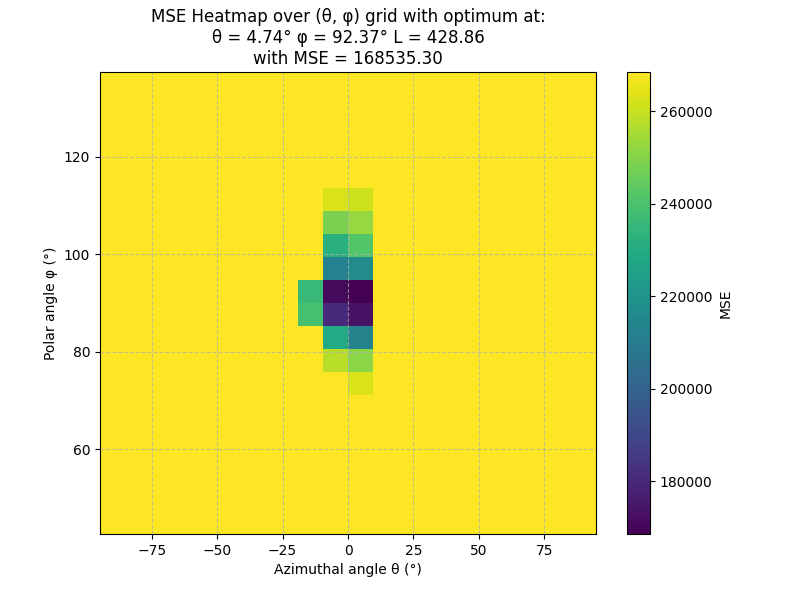

In [ ]:
MSP_pipeline(
    base_path =r"/home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean",
    output_path = r"/home/loriskeller/Documents/Master Project/Results/12.05.25/Huber Loss 300, thresh 300,2500",
    structure_names = ["Image", "Body", "GTVp", "Spinal Cord", "Mandible"],
    slice_axis = 2,
    HU_range=[300, 2500],
    slice_range=None,
    azimuthal=(0, 90),
    polar=(90, 45),
    initialization_steps=20,
    delta=300,
    widget=True,
    patient = 187
)